# Information
Title: Artificial Intelligence in Insurance Claims Management - Computer vision for car damage recognition 

Author: Roman Kastl

# Training & Fine-tuning EfficientNetB0 - Module 3
- Use transfer learning to classify images according to the severity and extent of the damages
- EfficientNetB0

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

https://www.tensorflow.org/tutorials/images/transfer_learning

https://keras.io/examples/vision/image_classification_from_scratch/

https://studymachinelearning.com/keras-modeling-sequential-vs-functional-api/

https://www.tensorflow.org/guide/keras/functional


# Build, train, and save models

## Preparation

### Import the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import pathlib
import PIL
import random
import json
import datetime

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

#Only if we use colab
#from google.colab import files
from tensorboard.plugins.hparams import api as hp

#Library for model scheme
import pydot
import graphviz
import pydotplus

#Require tensorflow >= 2.3
import tensorflow
print(tensorflow.__version__)

2.4.0


In [2]:
#Make space into Google colab
!rm -rf logs
#!rm -rf Dataset_v3_cat_extent

In [4]:
model_version = "v4"
step_name ="Training and Fine-tuning"
module_name = "Module3"
drive_path = "/content/drive/My Drive/Colab Notebooks/"+step_name+"/"+module_name+"/"+model_version+"/"
load_drive = True
save_plot = True
save_data = False
save_history = True

In [5]:
from google.colab import drive
if load_drive == True:
  drive.mount('/content/drive')

Mounted at /content/drive


### Set seed value

In [6]:
# Set the Random Seed
seed_value= 123

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Check that model will run on GPU

In [7]:
from tensorflow.python.client import device_lib
import torch

torch.cuda.is_available()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9703150809284982555, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9561131865685385984
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Part 1 - Data Preprocessing


### - Recover data

Locally

In [9]:
#V1 - Recover from local dataset
#Get the path to the dataset folder
# path = os.getcwd()
# data_dir = pathlib.Path(path + "/reduced_dataset/")
# data_dir = pathlib.Path("D:/CODE/Python/Thesis/_dataset/CNN_binary_reduced_dataset")
# print(path)
# print(data_dir)


From Google drive

In [10]:
#!gdown --id 1_EEaL9XamxtaO2TC2O02wU_8MdIB-A7d
dataset_name = "Dataset_v3_cat_extent"
!tar -xvf  '/content/drive/MyDrive/Colab Notebooks/Thesis_dataset/Module3.tar.gz' -C '/content'
data_dir = pathlib.Path("/content/"+dataset_name)

Dataset_v3_cat_extent/
Dataset_v3_cat_extent/damage-light/
Dataset_v3_cat_extent/damage-light/damage-L1-0.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-1.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-10.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-100.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-101.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-102.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-103.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-104.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-105.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-106.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-107.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-108.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-109.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-11.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-110.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-111.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-112.jpg
Dataset_v3_cat_extent/damage-light/damage-L1-1

### - Filter out badly encrypted image

In [11]:
#Source https://keras.io/examples/vision/image_classification_from_scratch/
num_skipped = 0
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


### - Count the number of existing image and display

In [12]:
#count the total number of image
image_count = len(list(data_dir.glob('*/*/')))
print(image_count)

1118


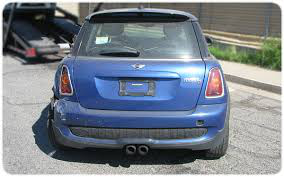

In [13]:
#Display a car
damage = list(data_dir.glob('*/*/'))
PIL.Image.open(str(damage[23]))

### Pre-process the images and prepare the training, validation and test set
This part split the dataset in a training (80%) and test dataset (20%)

In [14]:
#Preprocess the picture and prepare the set keras
#batch_size = 64
batch_size = 32
img_size = (224,224)

In [15]:
#Generate a training and validation dataset, in the next cell, a test dataset is generated from the validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size= img_size ,
  shuffle=True,
  batch_size=batch_size)
  
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=img_size,
  shuffle=True,
  batch_size=batch_size)

Found 1118 files belonging to 3 classes.
Using 895 files for training.
Found 1118 files belonging to 3 classes.
Using 223 files for validation.


In [16]:
#Skip the test set and only use a training and validation set for Module 2 and 3, due to the limited quantity of training data

#As not test dataset is available, we will extract a few pictures from the validation dataset
#source https://www.tensorflow.org/tutorials/images/transfer_learning
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 6
Number of test batches: 1


In [17]:
target_dict={k: v for v, k in enumerate(np.unique(train_ds.class_names))}
class_names = np.array(train_ds.class_names)
num_classes = len(class_names)
print(class_names)
print(num_classes)

['damage-light' 'damage-medium' 'damage-severe']
3


### Display a few images of each class

As we can observed, 0 refers to the damage class and 1 to regular car pictures

In [18]:
for images, labels in train_ds.take(1):
    for i in range(9):
        #print(labels[i])
        print(class_names[np.argmax(labels[i])])

damage-medium
damage-medium
damage-medium
damage-medium
damage-severe
damage-severe
damage-severe
damage-medium
damage-severe


In [19]:
preds = np.array([0.3,0.2,0.3])
class_preds = np.argmax(preds)
print(preds)
print(class_names)
print(class_preds)

result = (np.vstack((class_names,preds)).T).tolist()
result.sort(key=lambda x: x[1], reverse =True)
print(result)

[0.3 0.2 0.3]
['damage-light' 'damage-medium' 'damage-severe']
0
[['damage-light', '0.3'], ['damage-severe', '0.3'], ['damage-medium', '0.2']]


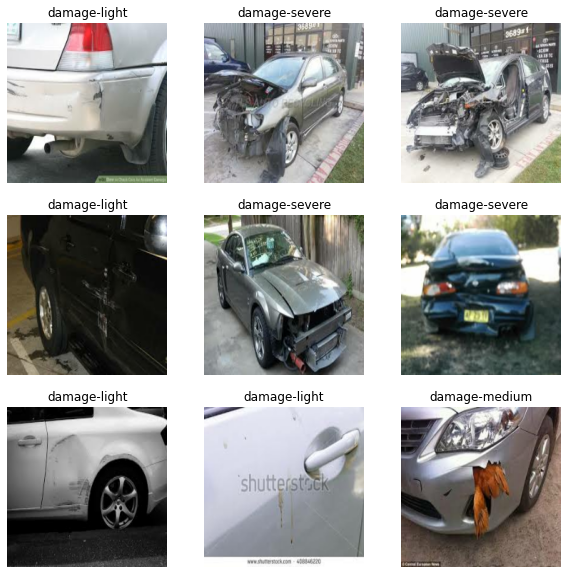

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [21]:
#Print dataset format
# Here we use a batch of 32, the image dimensions are 224x224 and RGB (3)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 3)


### Configure dataset for performance

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Part 2 - Build the model

### Build Callbacks and Training method

Callback: 

- EarlyStopping: Stop training the model if loss on validation set has not improved over 3 iterations
- ModelCheckpoint: Save the best model based on the validation accuracy
- WIP - TensorBoard: Generate the data for a tensorboard 


Model:
- EfficientNet-B0

In [23]:
def train_model(model_to_train,callbacks, epochs):
    model_to_train
    history_model_to_train = model_to_train.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    return(model_to_train,history_model_to_train)

In [24]:
### COMPILE THE MODEL
if num_classes == 2:
    loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    METRICS = [
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=1,threshold=0.5, name='f1-score')
        ]
else:
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    METRICS = [
             'accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),             
             tfa.metrics.F1Score(name='f1-score',average='macro',num_classes=num_classes,threshold=0.5)
             #tfa.metrics.F1Score(name='f1-score_perClass',num_classes=num_classes,threshold=0.5)             
             #tfa.metrics.F1Score(name='f1-score',average='macro',num_classes=num_classes,threshold=0.5)
            ]

In [25]:
def build_callback(model_name, patience, verbose):
    callbacks_list = [
     keras.callbacks.EarlyStopping(
         monitor="val_loss",
         patience=patience,
         verbose=verbose,
         mode="auto",
         restore_best_weights=True,
     ),
      keras.callbacks.TensorBoard(
          log_dir="logs/fit/"+model_name,
          histogram_freq=1,
          embeddings_freq=1,
          )]
    if save_data == True:
      {
        callbacks_list.append(
         keras.callbacks.ModelCheckpoint(
         filepath=drive_path+""+model_name+".h5",
         monitor="val_loss",
         save_best_only=True,
     ))
      }

    return(callbacks_list)


### Data augmentation

In this code data augmentation is achieved through layers which are added to the model

In [26]:
#Create layer for image augmentation
#It will help to prevent overfitting
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    #layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomZoom(0.1),
    #layers.experimental.preprocessing.RandomContrast(0.05)
  ]
)

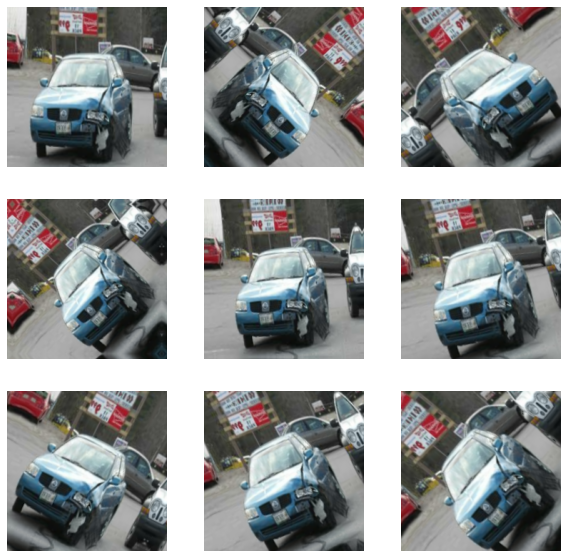

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Build and Compile EfficientNetB0
- Initialize
- Pass Data augmentation
- Rescale /255, /127.5 and 0;1 or -1;1 depending on the model transferred
- Output layer - Sigmoid function (Binary output)
### Model inspired from:

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

https://www.tensorflow.org/tutorials/images/transfer_learning

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/


In [28]:
from tensorflow.keras.applications import EfficientNetB0

#Make the EfficientNetB0 model
def make_model_EfficientNetB0(input_shape, num_classes, model_arch_name):

    ### BUILD THE MODEL
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    preprocess_input_EfficientNetB0 = keras.applications.efficientnet.preprocess_input
    x = preprocess_input_EfficientNetB0(x)
    
    #We do not want the base to be trainable, otherwise we would lose all the advantagres of using pre-trained model
    #conv_base_EfficientNetB0  = EfficientNetB0(weights='imagenet',include_top=False,input_tensor=x, drop_connect_rate=0.2)      
    conv_base_EfficientNetB0  = EfficientNetB0(weights='imagenet',include_top=False,input_tensor=x)      
    conv_base_EfficientNetB0.trainable = False
    conv_base_EfficientNetB0.summary()

    #x = conv_base_EfficientNetB0(x)
    

    #Rebuild top
    #Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(conv_base_EfficientNetB0.output)
    #x = layers.BatchNormalization()(x)

    #x = layers.Dropout(0.5, name="top_dropout")(x) 
    #x = layers.Dense(128,activation='relu')(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    outputs = layers.Dense(units, activation=activation, name="pred")(x)
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    
    #would use 1e-5 for fine-tuning
    #a learning rate of 1e-2 reduced the valuation f1
    opt = Adam(lr=1e-3)
    
    model.compile(optimizer=opt, loss=loss_func, metrics=METRICS)
    
    #model.summary()
    if (save_plot == True):
      keras.utils.plot_model(model,show_shapes=True,to_file=drive_path+model_arch_name+"_plot.png")
    return(model)

### Build chart to evaluate the model training process

In [29]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics

In [30]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, key):
  metrics =  ['accuracy','loss','f1-score']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history[metric], color=colors[0], label='Train')
    plt.plot(history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()
    fig = plt.gcf()
    if(save_data == True):
      fig.savefig(drive_path+key+"_training_plot.png", dpi=300)

### JSON export

In [31]:
def json_export(name, data):
  data['f1-score'] = list(map(float, data['f1-score']))
  data['val_f1-score'] = list(map(float, data['val_f1-score']))
  json.dump(data, open(drive_path+module_name+"_"+model_version+"_history_dict_"+name+".json", 'w'))

## Part 3 - Compile, train and assess EfficientNet-B0
Can only run one of the below, must restart the session in between the compilation of two model. The goal is to uniform the tests

###Compile and summary of EfficientNet-B0

In [32]:
tensorflow.keras.backend.clear_session()
model_EfficientNetB0 = make_model_EfficientNetB0(img_size+(3,),num_classes, "EfficientNetB0")
#model_EfficientNetB0 = compile_model(model_EfficientNetB0,"EfficientNetB0")
model_EfficientNetB0.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
____________________

### Train EfficientNetB0

In [33]:
#Set to 30 because we do not want early stopping for cause of Visual rendering, but we still use early stopping in order to restore the best weights
epochs = 30
patience = 30
verbose = 1

tensorflow.keras.backend.clear_session()
callbacks_EfficientNetB0 = build_callback("EfficientNetB0", patience, verbose)
model_EfficientNetB0, history_model_EfficientNetB0 = train_model(model_EfficientNetB0, callbacks_EfficientNetB0, epochs)
# Save it under the form of a json file
if save_history == True:
  json_export("EfficientNetB0", history_model_EfficientNetB0.history)

Epoch 1/30
28/28 [==============================] - 16s 186ms/step - loss: 1.0062 - accuracy: 0.5214 - precision: 0.6328 - recall: 0.1990 - f1-score: 0.2920 - val_loss: 0.8388 - val_accuracy: 0.5602 - val_precision: 0.6581 - val_recall: 0.4031 - val_f1-score: 0.4672
Epoch 2/30
28/28 [==============================] - 2s 88ms/step - loss: 0.7914 - accuracy: 0.6278 - precision: 0.7001 - recall: 0.4779 - f1-score: 0.5715 - val_loss: 0.7507 - val_accuracy: 0.6754 - val_precision: 0.7500 - val_recall: 0.4712 - val_f1-score: 0.5794
Epoch 3/30
28/28 [==============================] - 2s 88ms/step - loss: 0.7194 - accuracy: 0.6867 - precision: 0.7695 - recall: 0.5453 - f1-score: 0.6300 - val_loss: 0.7443 - val_accuracy: 0.6806 - val_precision: 0.7059 - val_recall: 0.5026 - val_f1-score: 0.5657
Epoch 4/30
28/28 [==============================] - 2s 87ms/step - loss: 0.6695 - accuracy: 0.7091 - precision: 0.7864 - recall: 0.6010 - f1-score: 0.6746 - val_loss: 0.7114 - val_accuracy: 0.6702 - val_

In [34]:
history_model_EfficientNetB0.history

{'accuracy': [0.5474860072135925,
  0.6536312699317932,
  0.6737430095672607,
  0.6927374005317688,
  0.721787691116333,
  0.7284916043281555,
  0.7396647930145264,
  0.7698323726654053,
  0.7497206926345825,
  0.7586592435836792,
  0.7452514171600342,
  0.7642458081245422,
  0.7675977945327759,
  0.7765362858772278,
  0.7709497213363647,
  0.7765362858772278,
  0.7910614609718323,
  0.7843575477600098,
  0.7932960987091064,
  0.7932960987091064,
  0.8011173009872437,
  0.7932960987091064,
  0.8033519387245178,
  0.813407838344574,
  0.8167597651481628,
  0.8078212141990662,
  0.8122904896736145,
  0.818994402885437,
  0.7977653741836548,
  0.8122904896736145],
 'f1-score': [0.3970893323421478,
  0.594548761844635,
  0.6293272376060486,
  0.6724579334259033,
  0.6867491602897644,
  0.7157521843910217,
  0.7083048820495605,
  0.7495554089546204,
  0.7367327809333801,
  0.7365453243255615,
  0.7288427352905273,
  0.7496075630187988,
  0.7504136562347412,
  0.7753525376319885,
  0.7673012

### Chart the model EfficientNet-B0

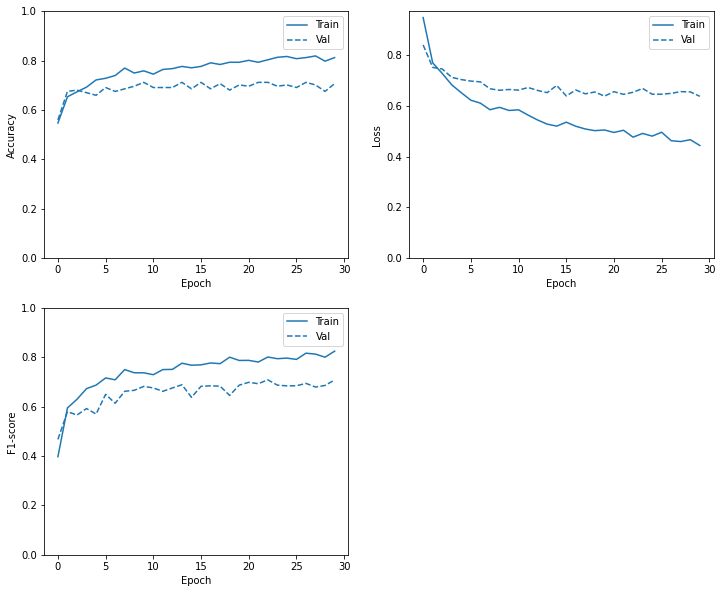

In [35]:
# Read the Json
#history_dict_EfficientNetB0 = json.load(open("history_dict_EfficientNetB0.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_EfficientNetB0.history,"EfficientNetB0")

## Part 4 - Fine-tune the model

Source: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

### Determine layers to unfreeze

In [36]:
 #model_EfficientNetB0.summary()
 
for layer in model_EfficientNetB0.layers[-18:]:
  print(layer)

### Build unfreeze_model method

In [37]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers, corresponding to the Block 7 of the EfficientNet-B0 model, use 21 if the Dense 128 layer is added on top
    for layer in model.layers[-18:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    #would use 1e-5 for fine-tuning
    opt = Adam(lr=1e-4)
    
    model.compile(optimizer=opt, loss=loss_func, metrics=METRICS)

unfreeze_model(model_EfficientNetB0)

In [38]:
model_EfficientNetB0.summary()

Model: "EfficientNetB0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
_____________________________________________________________________________________

### Train the fine-tuned model

In [39]:
#Set to 10 because we do not want early stopping for cause of Visual rendering, but we still use early stopping in order to restore the best weights
epochs = 30
patience = 30
verbose = 1

callbacks_EfficientNetB0 = build_callback("EfficientNetB0_ft", patience, verbose)
model_EfficientNetB0, history_model_EfficientNetB0 = train_model(model_EfficientNetB0, callbacks_EfficientNetB0, epochs)
# Save it under the form of a json file
if save_history == True:
  json_export("EfficientNetB0_ft", history_model_EfficientNetB0.history)

Epoch 1/30
28/28 [==============================] - 11s 179ms/step - loss: 0.4735 - accuracy: 0.8045 - precision: 0.7977 - recall: 0.7390 - f1-score: 0.7720 - val_loss: 0.6395 - val_accuracy: 0.7016 - val_precision: 0.7062 - val_recall: 0.6545 - val_f1-score: 0.6874
Epoch 2/30
28/28 [==============================] - 3s 95ms/step - loss: 0.4400 - accuracy: 0.8176 - precision: 0.8342 - recall: 0.7806 - f1-score: 0.8065 - val_loss: 0.6525 - val_accuracy: 0.6911 - val_precision: 0.7184 - val_recall: 0.6545 - val_f1-score: 0.6869
Epoch 3/30
28/28 [==============================] - 3s 95ms/step - loss: 0.4110 - accuracy: 0.8352 - precision: 0.8454 - recall: 0.8212 - f1-score: 0.8344 - val_loss: 0.6517 - val_accuracy: 0.6859 - val_precision: 0.7110 - val_recall: 0.6440 - val_f1-score: 0.6784
Epoch 4/30
28/28 [==============================] - 3s 96ms/step - loss: 0.3753 - accuracy: 0.8582 - precision: 0.8764 - recall: 0.8292 - f1-score: 0.8532 - val_loss: 0.7058 - val_accuracy: 0.6649 - val_

### Chart the fine-tuned model

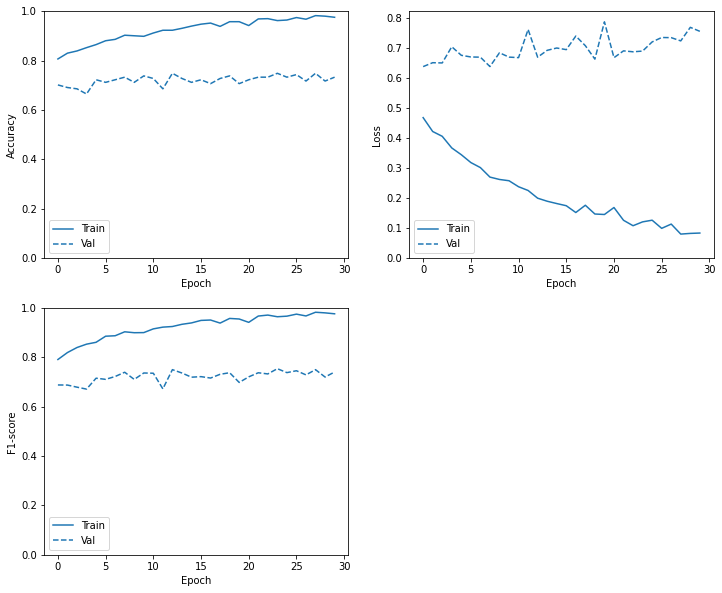

In [40]:
# Read the Json
#history_dict_EfficientNetB0 = json.load(open("history_dict_EfficientNetB0.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_EfficientNetB0.history,"EfficientNetB0_ft")

#CAM

In [41]:
# Display
from IPython.display import Image
import matplotlib.cm as cm

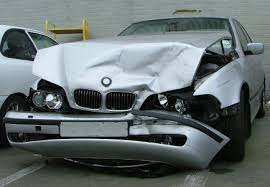

In [164]:
preprocess_input = keras.applications.efficientnet.preprocess_input
decode_predictions = keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_activation"
classifier_layer_names = [
    "global_average_pooling2d",
    "pred",
]

# The local path to our target image
img_path = "damage-L3-76.jpg"
save_path = img_path+"_CAM.jpg"


display(Image(img_path))

In [165]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [166]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

Predicted: damage-severe


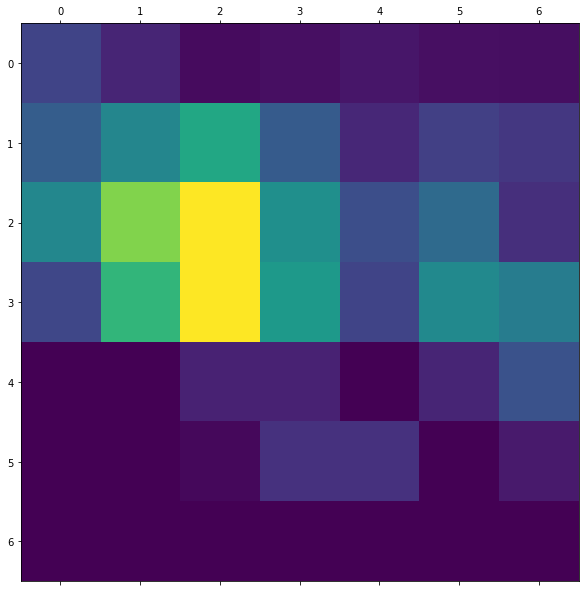

In [167]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_EfficientNetB0

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", class_names[preds.argmax()])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

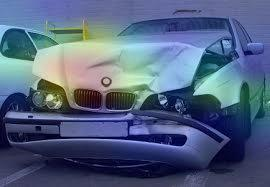

In [168]:
#We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

# Tensorboard

In [ ]:
#https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb#scrollTo=Ycz766H-zSwh

#!rm -rf ./logs/fit/VGG16_20201217-113236
#!tensorboard dev list
#!tensorboard dev delete --experiment_id 5zMkplkwTaSjc4WvnzFE1g

In [ ]:
#Update to Tensorboard
!tensorboard dev upload --logdir ./logs/fit/EfficientNetB0 \
  --name "Training & Fine-tuning - Module 3 - v1" \
  --description "EfficientNet-B0 Dense=128, Dropout=0.5, batch_norm" \
  --one_shot

2021-01-06 18:00:22.697056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/I2pjTMP1SD6i7hA5xG9qWA/

[2021-01-06T18:00:24] Started scanning logdir.
[2021-01-06T18:00:56] Total uploaded: 300 scalars, 9624 tensors (11.5 MB), 1 binary objects (911.9 kB)
[2021-01-06T18:00:56] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/I2pjTMP1SD6i7hA5xG9qWA/


In [ ]:
#Update to Tensorboard
!tensorboard dev upload --logdir ./logs/fit/EfficientNetB0_ft \
  --name "Training & Fine-tuning - Module 3 - v1" \
  --description "EfficientNet-B0 fine-tuned Dense=128, Dropout=0.5 and batch_norm" \
  --one_shot

2021-01-06 18:01:09.064037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/7LbBjqLQTjOKYgEzd1r1cA/

[2021-01-06T18:01:10] Started scanning logdir.
[2021-01-06T18:01:42] Total uploaded: 300 scalars, 9624 tensors (11.5 MB), 1 binary objects (922.2 kB)
[2021-01-06T18:01:42] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/7LbBjqLQTjOKYgEzd1r1cA/


In [ ]:
#Update to Tensorboard
!tensorboard dev upload --logdir ./logs \
  --name "Training & Fine-tuning - Module 3 - v1" \
  --description "EfficientNet-B0 pre and post fine-tuning Dense=128, Dropout=0.5 and batch_norm" \
  --one_shot

2021-01-06 18:02:41.082267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/j4JO1R87QMCdgukJec0eWQ/

[2021-01-06T18:02:42] Started scanning logdir.
[2021-01-06T18:03:47] Total uploaded: 600 scalars, 19249 tensors (23.0 MB), 2 binary objects (1.8 MB)
[2021-01-06T18:03:47] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/j4JO1R87QMCdgukJec0eWQ/


## Access Tensorboard and build chart

https://www.tensorflow.org/tensorboard/dataframe_api

In [ ]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [ ]:
experiment_id = "j4JO1R87QMCdgukJec0eWQ"

experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
dfw = experiment.get_scalars(pivot=True) 
dfw

,run,step,epoch_accuracy,epoch_f1-score,epoch_loss,epoch_precision,epoch_recall
0,fit/EfficientNetB0/train,0,0.512849,0.510425,1.516391,0.518779,0.493855
1,fit/EfficientNetB0/train,1,0.603352,0.609980,1.064954,0.624703,0.587709
2,fit/EfficientNetB0/train,2,0.662570,0.662302,0.838253,0.674419,0.648045
3,fit/EfficientNetB0/train,3,0.696089,0.700012,0.748989,0.708333,0.683799
4,fit/EfficientNetB0/train,4,0.696089,0.695036,0.770064,0.708285,0.678212
...,...,...,...,...,...,...,...
115,fit/EfficientNetB0_ft/validation,25,0.759162,0.755991,0.725054,0.767568,0.743455
116,fit/EfficientNetB0_ft/validation,26,0.743455,0.750407,0.744720,0.758065,0.738220
117,fit/EfficientNetB0_ft/validation,27,0.743455,0.747005,0.730227,0.750000,0.738220
118,fit/EfficientNetB0_ft/validation,28,0.753927,0.751059,0.726615,0.758065,0.738220


In [ ]:
csv_path = drive_path+module_name+"_"+model_version+"_experiment.csv"
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

In [ ]:
dfw

,run,step,epoch_accuracy,epoch_f1-score,epoch_loss,epoch_precision,epoch_recall
0,fit/EfficientNetB0/train,0,0.512849,0.510425,1.516391,0.518779,0.493855
1,fit/EfficientNetB0/train,1,0.603352,0.609980,1.064954,0.624703,0.587709
2,fit/EfficientNetB0/train,2,0.662570,0.662302,0.838253,0.674419,0.648045
3,fit/EfficientNetB0/train,3,0.696089,0.700012,0.748989,0.708333,0.683799
4,fit/EfficientNetB0/train,4,0.696089,0.695036,0.770064,0.708285,0.678212
...,...,...,...,...,...,...,...
115,fit/EfficientNetB0_ft/validation,25,0.759162,0.755991,0.725054,0.767568,0.743455
116,fit/EfficientNetB0_ft/validation,26,0.743455,0.750407,0.744720,0.758065,0.738220
117,fit/EfficientNetB0_ft/validation,27,0.743455,0.747005,0.730227,0.750000,0.738220
118,fit/EfficientNetB0_ft/validation,28,0.753927,0.751059,0.726615,0.758065,0.738220


In [ ]:
dfw_validation

,run,step,epoch_accuracy,epoch_f1-score,epoch_loss,epoch_precision,epoch_recall
30,fit/EfficientNetB0/validation,0,0.617801,0.548962,0.785742,0.679389,0.465969
31,fit/EfficientNetB0/validation,1,0.680628,0.595980,0.753680,0.796460,0.471204
32,fit/EfficientNetB0/validation,2,0.675393,0.584938,0.741656,0.744186,0.502618
33,fit/EfficientNetB0/validation,3,0.670157,0.618854,0.749169,0.770992,0.528796
34,fit/EfficientNetB0/validation,4,0.654450,0.599129,0.720823,0.742647,0.528796
35,fit/EfficientNetB0/validation,5,0.701571,0.639739,0.665058,0.746479,0.554974
36,fit/EfficientNetB0/validation,6,0.675393,0.630137,0.669953,0.705882,0.565445
37,fit/EfficientNetB0/validation,7,0.675393,0.680631,0.664995,0.733333,0.633508
38,fit/EfficientNetB0/validation,8,0.675393,0.634122,0.689154,0.678571,0.596859
39,fit/EfficientNetB0/validation,9,0.685864,0.655732,0.689816,0.729560,0.607330


In [ ]:
dfw_validation

,run,step,epoch_accuracy,epoch_f1-score,epoch_loss,epoch_precision,epoch_recall
30,fit/EfficientNetB0/validation,0,0.617801,0.548962,0.785742,0.679389,0.465969
31,fit/EfficientNetB0/validation,1,0.680628,0.595980,0.753680,0.796460,0.471204
32,fit/EfficientNetB0/validation,2,0.675393,0.584938,0.741656,0.744186,0.502618
33,fit/EfficientNetB0/validation,3,0.670157,0.618854,0.749169,0.770992,0.528796
34,fit/EfficientNetB0/validation,4,0.654450,0.599129,0.720823,0.742647,0.528796
35,fit/EfficientNetB0/validation,5,0.701571,0.639739,0.665058,0.746479,0.554974
36,fit/EfficientNetB0/validation,6,0.675393,0.630137,0.669953,0.705882,0.565445
37,fit/EfficientNetB0/validation,7,0.675393,0.680631,0.664995,0.733333,0.633508
38,fit/EfficientNetB0/validation,8,0.675393,0.634122,0.689154,0.678571,0.596859
39,fit/EfficientNetB0/validation,9,0.685864,0.655732,0.689816,0.729560,0.607330


Text(0.5, 1.0, 'loss')

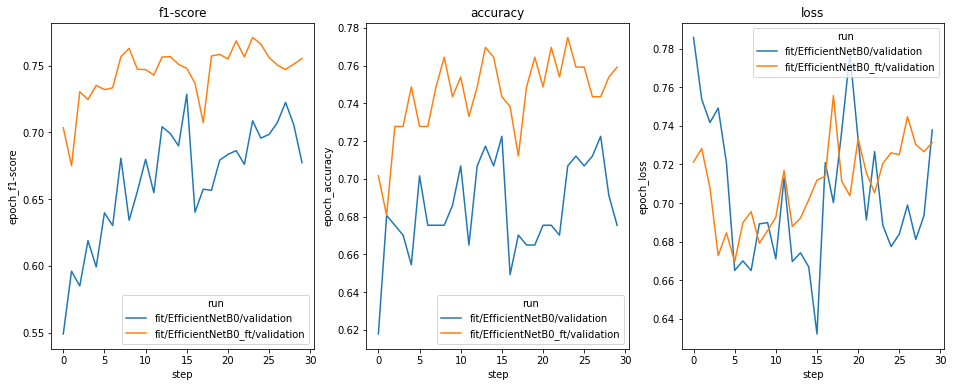

In [ ]:
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_validation = dfw[dfw.run.str.endswith("/validation")]
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dfw_validation, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 3, 2)
sns.lineplot(data=dfw_validation, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 3, 3)
sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

In [ ]:
dfw.groupby('run')['epoch_f1-score'].nlargest(1,)


run                                  
fit/EfficientNetB0/train          29     0.866214
fit/EfficientNetB0/validation     45     0.728434
fit/EfficientNetB0_ft/train       83     0.971995
fit/EfficientNetB0_ft/validation  113    0.771008
Name: epoch_f1-score, dtype: float64

### EfficientNet-B0

In [ ]:
dfw_EfficientNetB0 = dfw[dfw.run.str.startswith("fit/EfficientNetB0/")]

Text(0.5, 1.0, 'loss')

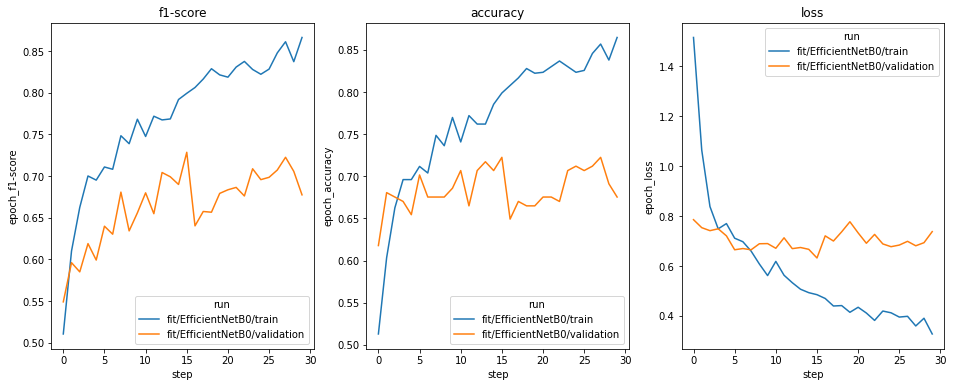

In [ ]:
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_EfficientNetB0.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 3, 2)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 3, 3)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

In [ ]:
dfw_EfficientNetB0_ft = dfw[dfw.run.str.startswith("fit/EfficientNetB0_ft")]

Text(0.5, 1.0, 'loss')

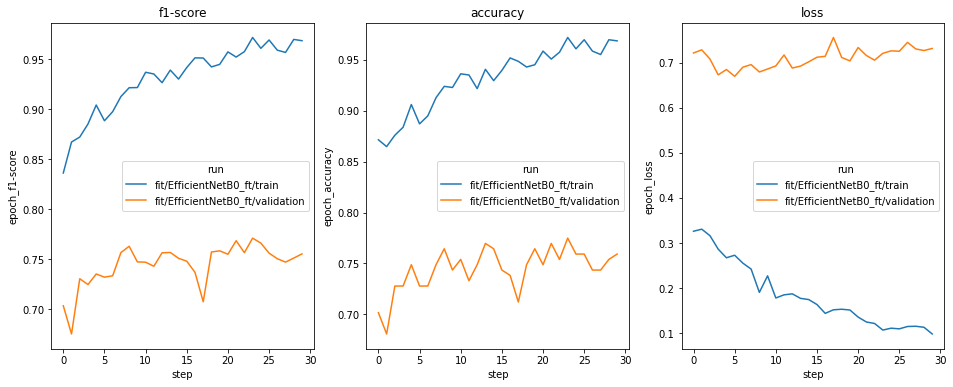

In [ ]:
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_EfficientNetB0_ft.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dfw_EfficientNetB0_ft, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 3, 2)
sns.lineplot(data=dfw_EfficientNetB0_ft, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 3, 3)
sns.lineplot(data=dfw_EfficientNetB0_ft, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

# Load and evaluate models

## Part 1 - Load the model and evaluate its accuracy

In [ ]:
model = model_EfficientNetB0
model_name = "EfficientNetB0"


In [ ]:
def model_accuracy():
  loss, acc, precision, recall, f1 = model.evaluate(test_ds)
  print('Restored model '+model_name+', accuracy: {:5.2f}%'.format(100*acc))
  print(model.predict(test_ds).shape)

In [ ]:
#from https://www.tensorflow.org/tutorials/keras/save_and_load
#model_VGG16 = tf.keras.models.load_model('V2_TRANSFER_VGG16_REDUCED.h5')
# Check its architecture
# model_vgg.summary()
# model_xception.summary()

model_accuracy()

1/1 [==============================] - 0s 411ms/step - loss: 0.9511 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - f1-score: 0.7448
Restored model EfficientNetB0, accuracy: 75.00%
(32, 3)


## Part 2 - Proceed to multiple predictions


In [ ]:
def model_predict():
  #Retrieve a batch of images from the test set
  image_batch, label_batch = test_ds.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  #print('Predictions:\n', predictions)
  #print('Labels:\n', label_batch)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    x = class_names[np.argmax(label_batch[i])]
    y = class_names[np.argmax(predictions[i])]
    plt.title("Actual:"+ x +"\nPredicted:"+ y +"")
    plt.axis("off")
  return predictions

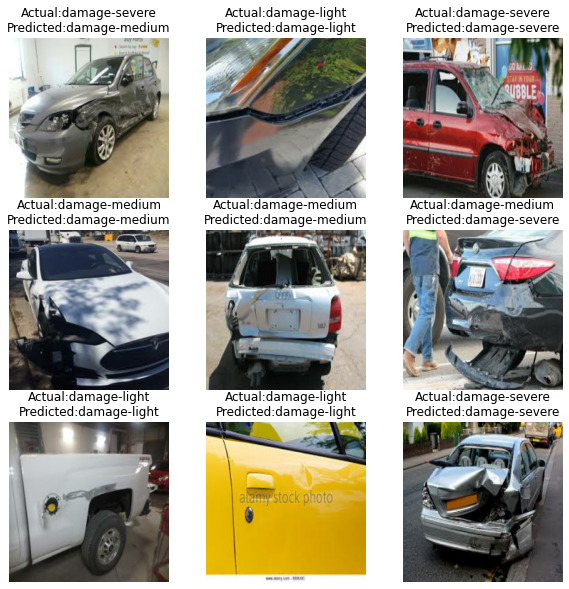

In [ ]:
predictions = model_predict()
#Retrieve a batch of images from the test set

In [ ]:
#Check
np.sum(predictions, axis=1)

array([0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       0.99999994, 0.99999994, 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.0000001 , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

## Part 3 - Single Prediction

In [ ]:
def model_predict_single():

  prediction = model.predict(img_array)

  #print(f"The alogirthm says this image is:\n {prediction[0,0]:.2%} {class_names[0]}\n and {prediction[0,1]:.2%} {class_names[1]}\n and {prediction[0,2]:.2%} {class_names[2]}\n")
  img.show()

The algorithm says this image is:
 98.49% damage-light
 and 1.41% damage-medium
 and 0.11% damage-severe



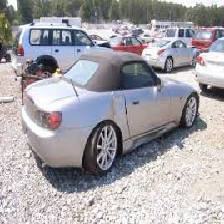

In [ ]:
img_path = "/content/Dataset_v3_cat_extent/damage-light/damage-L1-103.jpg"

img = keras.preprocessing.image.load_img(
      img_path, target_size=img_size
  )

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

prediction = model.predict(img_array)

print(f"The algorithm says this image is:\n {prediction[0,0]:.2%} {class_names[0]}\n and {prediction[0,1]:.2%} {class_names[1]}\n and {prediction[0,2]:.2%} {class_names[2]}\n")
img
